<a href="https://colab.research.google.com/github/keithlaspona/google-colab/blob/main/Phase4_Group3_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 4: Data Analysis and Machine Learning
**DMA / ADBMS Final Project**

Members:


*   Chris Andrei Irag*
*   Hernel Juanico
*   Keith Laspoña
*   Airyll Sanchez
*   Kobe Marco Olaguir
*   Ruszed Jy Ayad

University of Science and Technology of Southern Philippines

*chrisandrei.irag@1.ustp.edu.ph

In [1]:
#needed libraries
try:
  import os
  import psycopg2
  from sqlalchemy import create_engine
  from wordcloud import WordCloud

  import string
  import polars as pl
  import pandas as pd
  import requests

  import seaborn as sns
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools
  import networkx as nx

  import re
  import time
  from datetime import datetime

  from dotenv import load_dotenv; load_dotenv()
except ModuleNotFoundError:
  !pip install python-dotenv
  !pip install wordcloud
  from dotenv import load_dotenv; load_dotenv()

  print("""
  Please restart the kernel and upload your .env file if you haven't already.
  """)

#Database credentials

PGEND_POINT = os.environ["PGEND_POINT"]
PGDATABASE_NAME = os.environ["PGDATABASE_NAME"]
PGPORT = os.environ["PGPORT"]
PGUSER_NAME = os.environ["PGUSER_NAME"]
PGPASSWORD = os.environ["PGPASSWORD"]

#helper functions

def connect():

    conn_string = f"host={PGEND_POINT} port={PGPORT} dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"

    conn = psycopg2.connect(conn_string)
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\tConnected!')

    cursor = conn.cursor()

    return conn, cursor

def disconnect(conn):
    conn.close()
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\tDisconnected.')


def get_table(table: str):
    conn, cursor = connect()
    table = pl.read_database(f'SELECT * FROM {table}', conn)
    disconnect(conn)

    return table

def splitter(text: str):
  """
  Split a genre string into a list of strings.
  """
  text = re.sub(r'[{}"]', '', text)
  return re.findall(r'[^,]+', text)

def get_all_genres(series):
  """
  Get all unqiue genres from a series of genres.
  """
  es = set()
  for i in series:
    es = es | set(splitter(i))

  return es

def counter(word_list: list, dataframe):
  """
  Count the occurences of a list of words. Each count is added in a dataframe.
  """
  for i in word_list:
    if len(i) > 0:
      dataframe.loc[i, 'Count'] += 1

  return dataframe

# Genres descriptive stats

In [2]:
df = get_table('genres_season').to_pandas()
df

2024-12-05 18:33:00	Connected!
2024-12-05 18:33:01	Disconnected.


,anime_id,romaji_title,release_day,release_month,average_score,anime_popularity,num_of_episodes,episode_duration,num_of_favourites,anime_genres,anime_season,year
0,107372,Mahoutsukai ni Narenakatta Onnanoko no Hanashi.,5,10,62,8076,12,24,59,{Fantasy},FALL,2024
1,111314,Uzumaki,29,9,57,69169,4,23,968,"{Drama,Horror,Mystery,Supernatural}",FALL,2024
2,136880,BEASTARS FINAL SEASON Part 1,5,12,0,19760,0,0,125,"{Drama,Mystery,Psychological,""Slice of Life""}",FALL,2024
3,138522,Thunderbolt Fantasy: Touriken Yuuki 4,5,10,71,793,0,0,10,"{Action,Drama,Fantasy}",FALL,2024
4,141182,Seirei Gensouki 2,8,10,70,43191,12,24,1101,"{Action,Drama,Fantasy,Romance}",FALL,2024
...,...,...,...,...,...,...,...,...,...,...,...,...
109,183651,Kidou Senshi Gundam ALC ENCOUNTER,24,11,64,698,1,5,5,"{Mecha,Sci-Fi}",FALL,2024
110,184099,Agent Blue,10,11,49,132,1,1,1,{Horror},FALL,2024
111,184288,Kazuhiho to Marie no Youkoso Kitchen.,14,11,68,43,6,3,3,{Comedy},FALL,2024
112,184694,Ore dake Level Up na Ken: ReAwakening,29,11,81,2030,1,114,89,"{Action,Adventure,Fantasy}",FALL,2024


In [3]:
counter_index = get_all_genres(df['anime_genres'])

count_table = pd.DataFrame(
    {'Count': [0]},
    index=list(counter_index)
)

for idx, i in df.iterrows():
  count_table = counter(splitter(i['anime_genres']), count_table)

count_table['Presence'] = count_table['Count'] / len(df)
count_table.sort_values(by='Count', ascending=False, inplace=True)
count_table.head()

,Count,Presence
Comedy,40,0.350877
Action,36,0.315789
Fantasy,34,0.298246
Drama,30,0.263158
Romance,22,0.192982


In [4]:
count_table.to_csv('times_genres_associated.csv')

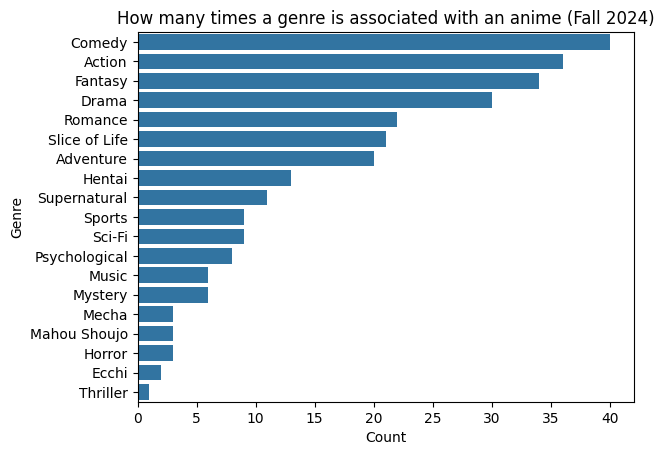

In [5]:
sns.barplot(data=count_table, y=count_table.index, x='Count',  orient='h')

plt.ylabel('Genre')
plt.title('How many times a genre is associated with an anime (Fall 2024)')
plt.savefig('times-associated.svg', format='svg', transparent=True)

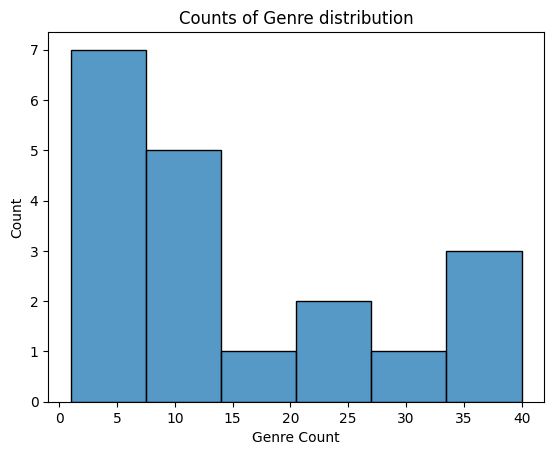

In [6]:
sns.histplot(data=count_table, x='Count')
plt.xlabel('Genre Count')
plt.title('Counts of Genre distribution')
plt.savefig('genre-distribution.svg', format='svg', transparent=True)

## Other descriptive stats

In [7]:
df.describe()

,anime_id,release_day,release_month,average_score,anime_popularity,num_of_episodes,episode_duration,num_of_favourites,year
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,172145.412281,11.684211,10.149123,59.824561,13100.122807,7.517544,18.587719,314.350877,2024.0
std,12523.729146,9.493655,1.199059,23.437828,22502.284677,7.767908,17.664429,819.300694,0.0
min,107372.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,2024.0
25%,169799.000000,5.000000,10.000000,58.250000,556.750000,0.000000,3.000000,11.000000,2024.0
50%,175078.000000,7.000000,10.000000,67.000000,2531.000000,6.000000,24.000000,44.500000,2024.0
75%,179795.500000,18.750000,10.000000,72.000000,19048.000000,12.000000,24.000000,290.500000,2024.0
max,184998.000000,31.000000,12.000000,95.000000,164980.000000,26.000000,114.000000,7491.000000,2024.0


In [8]:
df['release_day'] = df['release_day'].astype('string')
df['release_month'] = df['release_month'].astype('string')
df['year'] = df['year'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   anime_id           114 non-null    int64 
 1   romaji_title       114 non-null    object
 2   release_day        114 non-null    string
 3   release_month      114 non-null    string
 4   average_score      114 non-null    int64 
 5   anime_popularity   114 non-null    int64 
 6   num_of_episodes    114 non-null    int64 
 7   episode_duration   114 non-null    int64 
 8   num_of_favourites  114 non-null    int64 
 9   anime_genres       114 non-null    object
 10  anime_season       114 non-null    object
 11  year               114 non-null    string
dtypes: int64(6), object(3), string(3)
memory usage: 10.8+ KB


In [9]:
df[['release_month', 'release_day']] = df[['release_month', 'release_day']].replace(0, 1)
df[['release_month', 'release_day', 'year']].min()

<ipython-input-9-47c8e6c2c052>:2: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  df[['release_month', 'release_day', 'year']].min()


,0
release_month,0
release_day,0
year,2024


In [10]:
# df[['release_month', 'release_day']].replace(np.NaN, 1, inplace=True)
df['derived_date'] = df['release_month'] + '/' + df['release_day'] + '/' + df['year']

In [11]:
df['derived_date'] = df['derived_date'].apply(lambda x: re.sub(r'0/0/2024', '01/01/2024', x))


In [12]:
df

,anime_id,romaji_title,release_day,release_month,average_score,anime_popularity,num_of_episodes,episode_duration,num_of_favourites,anime_genres,anime_season,year,derived_date
0,107372,Mahoutsukai ni Narenakatta Onnanoko no Hanashi.,5,10,62,8076,12,24,59,{Fantasy},FALL,2024,10/5/2024
1,111314,Uzumaki,29,9,57,69169,4,23,968,"{Drama,Horror,Mystery,Supernatural}",FALL,2024,9/29/2024
2,136880,BEASTARS FINAL SEASON Part 1,5,12,0,19760,0,0,125,"{Drama,Mystery,Psychological,""Slice of Life""}",FALL,2024,12/5/2024
3,138522,Thunderbolt Fantasy: Touriken Yuuki 4,5,10,71,793,0,0,10,"{Action,Drama,Fantasy}",FALL,2024,10/5/2024
4,141182,Seirei Gensouki 2,8,10,70,43191,12,24,1101,"{Action,Drama,Fantasy,Romance}",FALL,2024,10/8/2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,183651,Kidou Senshi Gundam ALC ENCOUNTER,24,11,64,698,1,5,5,"{Mecha,Sci-Fi}",FALL,2024,11/24/2024
110,184099,Agent Blue,10,11,49,132,1,1,1,{Horror},FALL,2024,11/10/2024
111,184288,Kazuhiho to Marie no Youkoso Kitchen.,14,11,68,43,6,3,3,{Comedy},FALL,2024,11/14/2024
112,184694,Ore dake Level Up na Ken: ReAwakening,29,11,81,2030,1,114,89,"{Action,Adventure,Fantasy}",FALL,2024,11/29/2024


In [29]:
df['derived_date'] = pd.to_datetime(df['derived_date'], yearfirst=False)

KeyError: 'x'

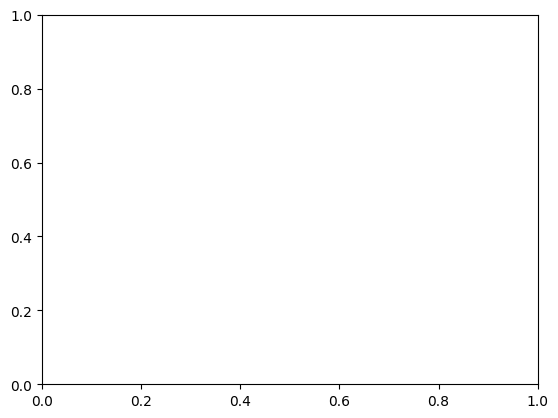

In [30]:
sns.lineplot(data=df, x=df[df['derived_date'] > ''], y='average_score')

## Co-occurence

In [15]:
occs = []
for idx, i in df.iterrows():
  genres = splitter(i['anime_genres'])
  if len(genres) > 0:
    occs.append(genres)

In [16]:
from collections import Counter
from itertools import combinations

# Create co-occurrence pairs
pairs = []
for genres in occs:
    pairs.extend(combinations(genres, 2))  # Generate all pairs for each occurrence

# Count co-occurrence frequencies
co_occurrence = Counter(pairs)
print(co_occurrence)


Counter({('Action', 'Fantasy'): 20, ('Action', 'Adventure'): 17, ('Adventure', 'Fantasy'): 15, ('Comedy', 'Fantasy'): 14, ('Action', 'Comedy'): 14, ('Comedy', 'Romance'): 13, ('Comedy', 'Slice of Life'): 12, ('Action', 'Drama'): 11, ('Drama', 'Romance'): 9, ('Drama', 'Fantasy'): 8, ('Comedy', 'Drama'): 8, ('Fantasy', 'Romance'): 7, ('Fantasy', 'Slice of Life'): 7, ('Drama', 'Supernatural'): 6, ('Action', 'Romance'): 6, ('Action', 'Sci-Fi'): 6, ('Adventure', 'Comedy'): 6, ('Drama', 'Psychological'): 5, ('Action', 'Psychological'): 5, ('Romance', 'Slice of Life'): 5, ('Action', 'Supernatural'): 5, ('Drama', 'Mystery'): 4, ('Drama', 'Slice of Life'): 4, ('Comedy', 'Sci-Fi'): 4, ('Action', 'Sports'): 4, ('Drama', 'Sports'): 4, ('Comedy', 'Supernatural'): 4, ('Adventure', 'Psychological'): 3, ('Fantasy', 'Psychological'): 3, ('Mecha', 'Sci-Fi'): 3, ('Adventure', 'Drama'): 3, ('Adventure', 'Romance'): 3, ('Slice of Life', 'Supernatural'): 3, ('Horror', 'Mystery'): 2, ('Mystery', 'Supernatura

In [17]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add edges with weights
for pair, weight in co_occurrence.items():
    G.add_edge(pair[0], pair[1], weight=weight)

In [18]:
G['Fantasy']['Action']

{'weight': 20}

In [19]:
num_colors = len(G.nodes())
cmap = plt.get_cmap('tab20')  # Use a discrete colormap like tab20 or tab10
colors = cmap(np.linspace(0, 1, num_colors))

In [20]:
count_table

,Count,Presence
Comedy,40,0.350877
Action,36,0.315789
Fantasy,34,0.298246
Drama,30,0.263158
Romance,22,0.192982
Slice of Life,21,0.184211
Adventure,20,0.175439
Hentai,13,0.114035
Supernatural,11,0.096491
Sports,9,0.078947


In [21]:
weighted_degree = dict(G.degree(weight="weight"))

In [22]:
node_calc = pd.DataFrame({
    'weighted_degree_scaled': [50 * weighted_degree[node] for node in G.nodes()],
    'presence_scaled': [100 * 100 * count_table.loc[node, 'Presence'] for node in G.nodes()]

}, index=G.nodes())

node_calc

,weighted_degree_scaled,presence_scaled
Drama,3500,2631.578947
Horror,200,263.157895
Mystery,550,526.315789
Supernatural,1400,964.912281
Psychological,1200,701.754386
Slice of Life,1850,1842.105263
Action,4600,3157.894737
Fantasy,4150,2982.456140
Romance,2550,1929.824561
Comedy,4100,3508.771930


In [23]:
node_calc['presence_scaled'].max()

3508.771929824561

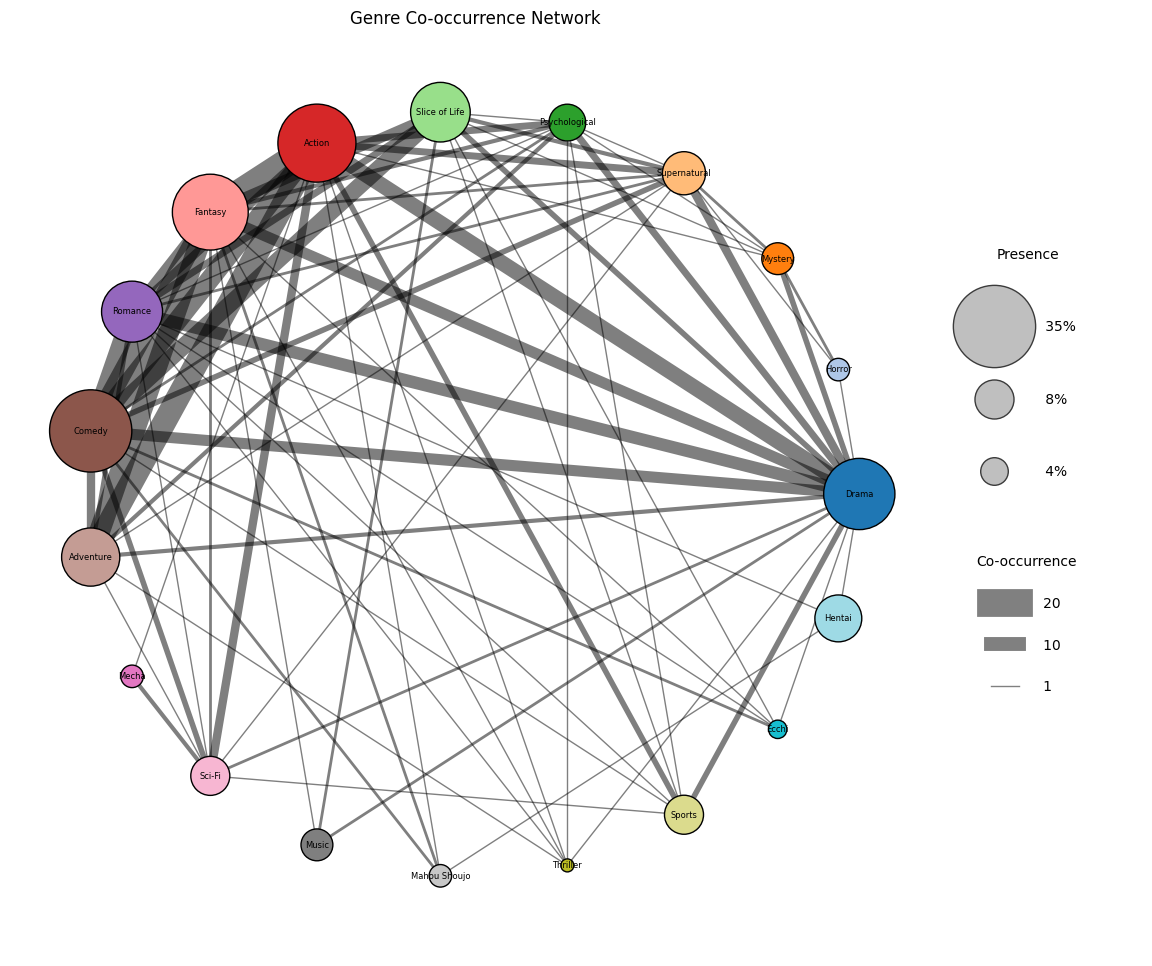

In [24]:
# Map weighted degree to node sizes
node_sizes = [50 * weighted_degree[node] for node in G.nodes()]

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 12))
pos = nx.circular_layout(G, scale=1, center=None, dim=2) # Layout of the nodes
nx.draw_networkx_nodes(G, pos, node_size=node_calc['presence_scaled'], node_color=colors, edgecolors='black', ax=ax)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=.5, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=6, font_color="black", ax=ax)

ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

#legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements1 = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor="#bfbfbf", markeredgecolor='#3b3b3b', markersize=((node_calc['presence_scaled'].max())**0.5), label=f"      {round(count_table['Presence'].max()*100)}%"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="#bfbfbf", markeredgecolor='#3b3b3b', markersize=((node_calc['presence_scaled'].median())**0.5), label=f"      {round(count_table['Presence'].median()*100)}%"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="#bfbfbf", markeredgecolor='#3b3b3b', markersize=((node_calc['presence_scaled'].quantile(0.25))**0.5), label=f"      {round(count_table['Presence'].quantile(.25)*100)}%"),
]
legend_elements2 = [
    Line2D([0], [0], color="gray", lw=20, markerfacecolor="gray", markeredgecolor='#3b3b3b', label="   20"),
    Line2D([0], [0], color="gray", lw=10, markerfacecolor="gray", markeredgecolor='#3b3b3b', label="   10"),
    Line2D([0], [0], color="gray", lw=1, markerfacecolor="gray", markeredgecolor='#3b3b3b',  label="   1"),
]

legend_elements3 = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor="#bfbfbf", markeredgecolor='#3b3b3b', markersize=50, label="", alpha=0),
]


legend1 = plt.legend(handles=legend_elements1, frameon=False, loc="upper right", labelspacing=4.2, title='Presence', bbox_to_anchor=(1.16, 0.78))
legend2 = plt.legend(handles=legend_elements2, frameon=False, loc="lower right", labelspacing=2.0, title='Co-occurrence', bbox_to_anchor=(1.16, 0.27))
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.legend(handles=legend_elements3 , loc="upper right", frameon=False, bbox_to_anchor=(1.225, 0.8))

plt.title("Genre Co-occurrence Network")
plt.savefig('co-occurence.svg', format='svg', transparent=True, bbox_inches="tight")


In [25]:
#node size
count_table

,Count,Presence
Comedy,40,0.350877
Action,36,0.315789
Fantasy,34,0.298246
Drama,30,0.263158
Romance,22,0.192982
Slice of Life,21,0.184211
Adventure,20,0.175439
Hentai,13,0.114035
Supernatural,11,0.096491
Sports,9,0.078947


In [26]:
#line thickness
edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
edge_weights[0:5]

[1, 4, 6, 5, 4]

In [27]:
# co-occurence
import pandas as pd
import itertools
counter_index = list(get_all_genres(df['anime_genres']))
# Sample data: list of lists, each list contains genres for one item (e.g., movie)
data = occs

# Initialize an empty set to collect all unique genres
unique_genres = itertools.chain(*data)  # Flatten and find unique elements

# Create a DataFrame with 0s, using unique genres as both columns and rows
occurrence_matrix = pd.DataFrame(0, index=counter_index, columns=counter_index)

# Populate the matrix with co-occurrence counts
for genres in data:
    # Generate all unique pairs of genres that occur together
    genre_pairs = itertools.combinations(genres, 2)
    # print(*genre_pairs)
    for g1, g2 in genre_pairs:
        occurrence_matrix.loc[g1, g2] += 1
        occurrence_matrix.loc[g2, g1] += 1  # Because the matrix is symmetric

# Display the occurrence matrix
occurrence_matrix

,Sports,Slice of Life,Hentai,Adventure,Action,Romance,Ecchi,Fantasy,Music,Horror,Sci-Fi,Drama,Supernatural,Comedy,Mystery,Mecha,Mahou Shoujo,Thriller,Psychological
Sports,0,1,0,0,4,1,0,0,0,0,1,4,0,1,0,0,0,0,1
Slice of Life,1,0,0,0,0,5,1,7,2,0,0,4,3,12,1,0,0,0,1
Hentai,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
Adventure,0,0,0,0,17,3,0,15,0,0,1,3,1,6,0,0,0,1,3
Action,4,0,0,17,0,6,0,20,0,0,6,11,5,14,1,1,1,1,5
Romance,1,5,1,3,6,0,1,7,0,0,1,9,2,13,0,0,0,1,1
Ecchi,0,1,0,0,0,1,0,1,0,0,0,1,0,2,0,0,0,0,0
Fantasy,0,7,0,15,20,7,1,0,1,0,2,8,2,14,0,0,2,1,3
Music,0,2,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0
Horror,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0


In [ ]:
data = [
    ['Action', 'Adventure', 'Fantasy'],
    ['Action', 'Sci-Fi'],
    ['Adventure', 'Fantasy'],
    ['Action', 'Adventure'],
    ['Fantasy', 'Sci-Fi']
]

# Function to get all unique genres
def get_all_genres(genre_lists):
    return set(itertools.chain(*genre_lists))

# Initialize an empty set to collect all unique genres
counter_index = list(get_all_genres(data))

# Create a DataFrame with 0s, using unique genres as both columns and rows
occurrence_matrix = pd.DataFrame(0, index=counter_index, columns=counter_index)

# Populate the matrix with co-occurrence counts
for genres in data:
    # Generate all unique pairs of genres that occur together
    genre_pairs = itertools.combinations(genres, 2)
    for g1, g2 in genre_pairs:
        occurrence_matrix.loc[g1, g2] += 1
        occurrence_matrix.loc[g2, g1] += 1  # Because the matrix is symmetric

# Display the occurrence matrix
print(occurrence_matrix)

# Visualization using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(occurrence_matrix, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Genre Co-occurrence Matrix')
plt.show()

In [ ]:
occurrence_matrix.to_csv('co-occurence-matrix.csv')
pd.Series(weighted_degree).to_csv('weighted-degree.csv')

Genre_a = []
Genre_b = []
weights = []

for i in G.edges(data=True):
  Genre_a.append(i[0])
  Genre_b.append(i[1])
  weights.append(i[2]['weight'])

pd.DataFrame({
    'Genre_a': Genre_a,
    'Genre_b': Genre_b,
    'weights': weights
}).to_csv('edge-weights.csv')

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# Data
data = {
    'Action': [0, 1, 1, 1],
    'Adventure': [1, 0, 1, 1],
    'Fantasy': [1, 1, 0, 0],
    'Sci-Fi': [0, 1, 0, 0]
}

# Create DataFrame
occurrence_matrix = pd.DataFrame(data, index=['Action', 'Adventure', 'Fantasy', 'Sci-Fi'])

# Create a graph from the co-occurrence matrix
G = nx.from_pandas_adjacency(occurrence_matrix)

# Calculate weighted degree for each node
weighted_degree = dict(G.degree(weight='weight'))

# Save weighted degree to CSV
pd.Series(weighted_degree).to_csv('weighted-degree.csv')

# Extract edges and their weights
Genre_a = []
Genre_b = []
weights = []

for i in G.edges(data=True):
    Genre_a.append(i[0])
    Genre_b.append(i[1])
    weights.append(i[2]['weight'])

# Save edge weights to CSV
pd.DataFrame({
    'Genre_a': Genre_a,
    'Genre_b': Genre_b,
    'weights': weights
}).to_csv('edge-weights.csv')

# Generate a different color for each node
colors = {node: "#{:06x}".format(random.randint(256,16777215)) for node in G.nodes()}

# Visualization using a network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=[v * 100 for v in weighted_degree.values()],
        node_color=[colors[node] for node in G.nodes()], font_size=10, font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})
plt.title('Genre Co-occurrence Network')
plt.show()

In [ ]:
counter = 0
for i in occs:
  if len(i) > counter:
    counter += 1

counter

## other metrics

In [ ]:
#prevalence
weighted_degree = dict(G.degree(weight="weight"))
weighted_degree

In [ ]:
# Weighted degree result
weighted_degree = {
    'Drama': 67,
    'Horror': 4,
    'Mystery': 8,
    'Supernatural': 28,
    'Action': 92,
    'Fantasy': 83,
    'Romance': 50,
    'Comedy': 81,
    'Adventure': 50,
    'Psychological': 21,
    'Mecha': 4,
    'Sci-Fi': 21,
    'Music': 5,
    'Slice of Life': 34,
    'Mahou Shoujo': 6,
    'Thriller': 6,
    'Sports': 13,
    'Ecchi': 6,
    'Hentai': 3
}

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(weighted_degree.keys(), weighted_degree.values(), color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Weighted Degree')
plt.title('Weighted Degree of Genres')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
degree_centrality = nx.degree_centrality(G)
degree_centrality

In [ ]:
# Degree centrality result
degree_centrality = {
    'Drama': 0.8888888888888888,
    'Horror': 0.16666666666666666,
    'Mystery': 0.2222222222222222,
    'Supernatural': 0.611111111111111,
    'Action': 0.7222222222222222,
    'Fantasy': 0.7222222222222222,
    'Romance': 0.7222222222222222,
    'Comedy': 0.6666666666666666,
    'Adventure': 0.5,
    'Psychological': 0.5,
    'Mecha': 0.1111111111111111,
    'Sci-Fi': 0.5,
    'Music': 0.16666666666666666,
    'Slice of Life': 0.4444444444444444,
    'Mahou Shoujo': 0.2222222222222222,
    'Thriller': 0.3333333333333333,
    'Sports': 0.38888888888888884,
    'Ecchi': 0.2777777777777778,
    'Hentai': 0.16666666666666666
}

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(degree_centrality.keys(), degree_centrality.values(), color='lightgreen')
plt.xlabel('Genre')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality of Genres')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")
betweenness_centrality

In [ ]:
# Betweenness centrality result
betweenness_centrality = {
    'Drama': 0.1000544662309368,
    'Horror': 0.014433551198257082,
    'Mystery': 0.011165577342047931,
    'Supernatural': 0.06023965141612201,
    'Action': 0.18338779956427015,
    'Fantasy': 0.09460784313725489,
    'Romance': 0.13316993464052287,
    'Comedy': 0.004575163398692811,
    'Adventure': 0.014433551198257082,
    'Psychological': 0.05501089324618736,
    'Mecha': 0.0,
    'Sci-Fi': 0.05582788671023965,
    'Music': 0.0,
    'Slice of Life': 0.015468409586056645,
    'Mahou Shoujo': 0.04379084967320261,
    'Thriller': 0.26296296296296295,
    'Sports': 0.09324618736383442,
    'Ecchi': 0.08616557734204795,
    'Hentai': 0.048583877995642705
}

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(betweenness_centrality.keys(), betweenness_centrality.values(), color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality of Genres')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
edge_betweenness = nx.edge_betweenness_centrality(G, weight="weight")
edge_betweenness


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Edge betweenness centrality result
edge_betweenness = {
    ('Drama', 'Horror'): 0.06798245614035087,
    ('Drama', 'Mystery'): 0.0037037037037037034,
    ('Drama', 'Supernatural'): 0.0,
    ('Drama', 'Action'): 0.0,
    ('Drama', 'Fantasy'): 0.0,
    ('Drama', 'Romance'): 0.0,
    ('Drama', 'Comedy'): 0.0,
    ('Drama', 'Slice of Life'): 0.0,
    ('Drama', 'Adventure'): 0.0,
    ('Drama', 'Psychological'): 0.0,
    ('Drama', 'Thriller'): 0.07105263157894735,
    ('Drama', 'Sci-Fi'): 0.00682261208576998,
    ('Drama', 'Sports'): 0.0,
    ('Drama', 'Ecchi'): 0.06666666666666665,
    ('Drama', 'Music'): 0.017543859649122806,
    ('Drama', 'Hentai'): 0.050536062378167636,
    ('Horror', 'Mystery'): 0.015399610136452241,
    ('Horror', 'Supernatural'): 0.047709551656920084,
    ('Mystery', 'Supernatural'): 0.026364522417153993,
    ('Mystery', 'Action'): 0.079775828460039,
    ('Supernatural', 'Fantasy'): 0.015545808966861599,
    ('Supernatural', 'Slice of Life'): 0.00253411306042885,
    ('Supernatural', 'Action'): 0.0,
    ('Supernatural', 'Adventure'): 0.024610136452241718,
    ('Supernatural', 'Comedy'): 0.0,
    ('Supernatural', 'Romance'): 0.0062865497076023385,
    ('Supernatural', 'Sci-Fi'): 0.04049707602339181,
    ('Supernatural', 'Psychological'): 0.04951267056530214,
    ('Action', 'Fantasy'): 0.0,
    ('Action', 'Romance'): 0.0,
    ('Action', 'Adventure'): 0.0,
    ('Action', 'Psychological'): 0.0,
    ('Action', 'Mecha'): 0.09502923976608187,
    ('Action', 'Sci-Fi'): 0.0,
    ('Action', 'Thriller'): 0.18918128654970756,
    ('Action', 'Comedy'): 0.0,
    ('Action', 'Sports'): 0.0,
    ('Action', 'Mahou Shoujo'): 0.06944444444444445,
    ('Fantasy', 'Romance'): 0.0,
    ('Fantasy', 'Adventure'): 0.0,
    ('Fantasy', 'Psychological'): 0.0,
    ('Fantasy', 'Comedy'): 0.0,
    ('Fantasy', 'Mahou Shoujo'): 0.01671539961013645,
    ('Fantasy', 'Thriller'): 0.097953216374269,
    ('Fantasy', 'Sci-Fi'): 0.012865497076023392,
    ('Fantasy', 'Slice of Life'): 0.0,
    ('Fantasy', 'Music'): 0.07309941520467836,
    ('Fantasy', 'Ecchi'): 0.05838206627680311,
    ('Romance', 'Comedy'): 0.0,
    ('Romance', 'Slice of Life'): 0.0,
    ('Romance', 'Adventure'): 0.0,
    ('Romance', 'Psychological'): 0.0287037037037037,
    ('Romance', 'Thriller'): 0.0766081871345029,
    ('Romance', 'Ecchi'): 0.06081871345029238,
    ('Romance', 'Sports'): 0.052729044834307987,
    ('Romance', 'Sci-Fi'): 0.043810916179337224,
    ('Romance', 'Hentai'): 0.07461013645224171,
    ('Comedy', 'Mahou Shoujo'): 0.0304093567251462,
    ('Comedy', 'Slice of Life'): 0.0,
    ('Comedy', 'Sci-Fi'): 0.021929824561403508,
    ('Comedy', 'Ecchi'): 0.021929824561403508
}

# Create a graph from the edge betweenness centrality result
G = nx.Graph()
for (u, v), betweenness in edge_betweenness.items():
    G.add_edge(u, v, weight=betweenness)

# Generate a different color for each node
colors = {node: "#{:06x}".format(random.randint(256,16777215)) for node in G.nodes()}

# Visualization using a network graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42) # Position nodes using Fruchterman-Reingold force-directed algorithm
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Change the color of every node to a different color
nx.draw(G, pos, with_labels=True, node_size=500, node_color=[colors[node] for node in G.nodes()],
        font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
plt.title('Edge Betweenness Centrality Network')
plt.show()

In [ ]:
density = nx.density(G)
density
clustering_coeff = nx.clustering(G)
clustering_coeff

In [ ]:
# Density Clustering coefficient result
clustering_coeff = {
    'Drama': 0.44166666666666665,
    'Horror': 1.0,
    'Mystery': 0.8333333333333334,
    'Supernatural': 0.6363636363636364,
    'Action': 0.5384615384615384,
    'Fantasy': 0.5641025641025641,
    'Romance': 0.6025641025641025,
    'Comedy': 0.6515151515151515,
    'Adventure': 0.8888888888888888,
    'Psychological': 0.8333333333333334,
    'Mecha': 1.0,
    'Sci-Fi': 0.7222222222222222,
    'Music': 1.0,
    'Slice of Life': 0.6785714285714286,
    'Mahou Shoujo': 0.5,
    'Thriller': 1.0,
    'Sports': 0.8095238095238095,
    'Ecchi': 1.0,
    'Hentai': 0.3333333333333333
}

# Create a bar chart for clustering coefficient
plt.figure(figsize=(12, 8))
plt.bar(clustering_coeff.keys(), clustering_coeff.values(), color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient of Genres')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.show()

# Density result
density = 0.5555555555555556

# Print the density result
print(f"Density of the network: {density}")

In [ ]:
clustering_coeff = nx.clustering(G)
clustering_coeff

In [ ]:
# Clustering coefficient result
clustering_coeff = {
    'Drama': 0.44166666666666665,
    'Horror': 1.0,
    'Mystery': 0.8333333333333334,
    'Supernatural': 0.6363636363636364,
    'Action': 0.5384615384615384,
    'Fantasy': 0.5641025641025641,
    'Romance': 0.6025641025641025,
    'Comedy': 0.6515151515151515,
    'Adventure': 0.8888888888888888,
    'Psychological': 0.8333333333333334,
    'Mecha': 1.0,
    'Sci-Fi': 0.7222222222222222,
    'Music': 1.0,
    'Slice of Life': 0.6785714285714286,
    'Mahou Shoujo': 0.5,
    'Thriller': 1.0,
    'Sports': 0.8095238095238095,
    'Ecchi': 1.0,
    'Hentai': 0.3333333333333333
}

# Create a bar chart for clustering coefficient
plt.figure(figsize=(12, 8))
plt.bar(clustering_coeff.keys(), clustering_coeff.values(), color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient of Genres')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.show()

14

## Long Format

In [ ]:
df = get_table('genres_season').to_pandas()
df.head(10)

In [ ]:
lf = df[['romaji_title', 'anime_genres', 'average_score', 'anime_popularity', 'num_of_favourites', 'num_of_episodes']].copy()
lf.head()

In [ ]:
lf_csv = pd.DataFrame(columns=['romaji_title', 'anime_genres'])

for idx, i in lf.iterrows():
  genres = splitter(i['anime_genres'])

  for j in genres:
    lf_csv = pd.concat(
        [
        lf_csv,
        pd.DataFrame({
            'romaji_title': [i['romaji_title']],
            'anime_genres': [j],
            'average_score': [i['average_score']],
            'anime_popularity': [i['anime_popularity']],
            'num_of_favourites': [i['num_of_favourites']],
            'num_of_episodes': [i['num_of_episodes']]
            })
        ],
        axis=0,
        ignore_index=True
        )

lf_csv.to_csv('anime_title_genres_long-format.csv', index=False)

# Text Analysis

In [ ]:
df = get_table('REVIEW_SENTIMENT_ANALYSIS').to_pandas()
df

In [ ]:
# Generate a word cloud from the 'review_text' column
text = ' '.join(df['review_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

In [ ]:
# Generate word cloud from the 'review_text' & 'review_title' columns
text = ' '.join(df['review_text'].tolist() + df['review_title'].tolist())
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

preprocessing

In [ ]:
## removing html code
try:
  import contractions
except Exception:
  !pip install contractions
  import contractions

In [ ]:
text = df['review_text'][0]
text

In [ ]:
len(df['review_text'][0])

In [ ]:
string.punctuation

In [ ]:
test = re.sub(f"\(https:(.*?)\)", '', contractions.fix(text)) #remove (https ... ) and expand contractions
test = re.sub(f"img(.*?)%", '', test) #remove img ... %
test = re.sub(f"(\n\n)", ' ', test) #replace new lines with a whitespace
test = re.sub("['" + r'…;:<>“”‘’!"#$%&~,—\-"\.+\?\*\^(\n)\[\]\{\}]+', '', test).lower() #special characters and random unique unicode characters
test

In [ ]:
word_list = re.split(r'\W+', test)

In [ ]:
#stop words removal
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


word_list = [word for word in word_list if word not in stop_words]

In [ ]:
# lemmatize
import nltk; nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

word_list_lemmatized = [lemmatizer.lemmatize(word, pos='a') for word in word_list]

In [ ]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(word_list_lemmatized)
bagofwords = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bagofwords

In [ ]:
import pandas as pd

# Convert the list to a Pandas DataFrame
word_list_df = pd.DataFrame(word_list_lemmatized, columns=['words'])

# Now you can use to_csv on the DataFrame
word_list_df.to_csv('word_list_lemmatized.csv', index=False)

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list_lemmatized))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
cloud = wordcloud.to_file('wordcloud.png')

In [ ]:
sns.barplot(data=bagofwords.sum().sort_values(ascending=False).head(30), orient='h')

# Machine learning

In [ ]:
df = get_table('genres_season').to_pandas()
df.head()

In [ ]:
# selecting features for machine learning
ml_data = df.drop(['anime_id', 'year', 'romaji_title', 'anime_genres', 'anime_season'], axis=1)
sns.heatmap(ml_data.corr(), annot=True)

num_of_favourites and anime_popularity seems highly related with each other, we drop this feature

### Trying out multiple models

Let's have our target variable 'average_score'

In [ ]:
ml_data.drop('anime_popularity', axis=1, inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# multiple linear regression
X = ml_data.drop('average_score', axis=1)
Y = ml_data['average_score']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

lm = LinearRegression().fit(X, Y)

In [ ]:
print('No splits, in-sample R2 score:', lm.score(X, y))

In [ ]:
lm = LinearRegression().fit(x_train, y_train)
print('With train split, in-sample R2 score', lm.score(x_train, y_train))

In [ ]:
print('With train split, out-of-sample R2 score', lm.score(x_test, y_test))

Verdict: poor performance

Conclusion:

The features do not explain the score, meaning that...
the release month and day of an anime show doesn't necessarily affect the average score nor does the episode count or duration. Let's try scaling down to simple linear regression


In [ ]:
X = ml_data[['num_of_favourites']]
Y = ml_data['average_score']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

lm = LinearRegression().fit(x_train, y_train)

In [ ]:
lm.score(x_test, y_test)

Verdict: very poor performance

Let's introduce feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# multiple linear regression
X = ml_data.drop('average_score', axis=1)
Y = ml_data['average_score']

In [ ]:
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

In [ ]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=13)

In [ ]:
lm = LinearRegression().fit(x_train, y_train)
lm.score(x_test, y_test)

Verdict: very poor

Excercise conclusion:

The features might not explain the average score but
results are still inconclusive, we need more data